In [7]:
import pyemma
import pickle
import os
import glob
import torch

import mdtraj as md
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt
import numpy as np

np.bool = np.bool_

from tqdm import tqdm
from matplotlib.colors import LogNorm
from itertools import combinations

blue = (70 / 255, 110 / 255, 250 / 255)
green = (100 / 255, 170 / 255, 120 / 255)

molecule = "1FME"
simulation_idx = 0
base_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-protein"
save_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein"
pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}.pdb"

# Visualization

In [21]:
name2letter = {
	"ALA": "A",
	"CYS": "C",
	"ASP": "D",
	"GLU": "E",
	"PHE": "F",
	"GLY": "G",
	"HIS": "H",
	"ILE": "I",
	"LYS": "K",
	"LEU": "L",
	"MET": "M",
	"ASN": "N",
	"PRO": "P",
	"GLN": "Q",
	"ARG": "R",
	"SER": "S",
	"THR": "T",
	"VAL": "V",
	"TRP": "W",
	"TYR": "Y",
	"NLE": "X",
}

pdb_traj = md.load_pdb(pdb_path) 
residue_names = [residue.name for residue in pdb_traj.topology.residues]
one_letter_str = ""
for idx, names in enumerate(residue_names):
    # print(f"Letter {idx}: {name2letter[names]}")
    one_letter_str += name2letter[names]
print(one_letter_str)

EQYTAKYKGRTFRNEKELRDFIEKFKGR


In [8]:
# PDB
pdb_traj = md.load_pdb(pdb_path)
pdb_view = nv.show_mdtraj(
    pdb_traj,
    height="400px",
    width="400px"
)
pdb_view.add_representation("licorice", selection="protein")

print(pdb_traj)
pdb_view

<mdtraj.Trajectory with 1 frames, 504 atoms, 28 residues, and unitcells>


NGLWidget()

In [9]:
# CA atom index
ca_atoms = [atom for atom in pdb_traj.topology.atoms if atom.name == "CA"]
ca_indices = [atom.index for atom in ca_atoms]

cnt = 1
for i in range(len(ca_indices)):
    for j in range(i+1, len(ca_indices)):
        print(f"d{cnt}: DISTANCE ATOMS={ca_indices[i]+1},{ca_indices[j]+1}")
        cnt += 1

print("ARG=" + ",".join(f"d{i+1}" for i in range(cnt)))

d1: DISTANCE ATOMS=5,20
d2: DISTANCE ATOMS=5,37
d3: DISTANCE ATOMS=5,58
d4: DISTANCE ATOMS=5,72
d5: DISTANCE ATOMS=5,82
d6: DISTANCE ATOMS=5,104
d7: DISTANCE ATOMS=5,125
d8: DISTANCE ATOMS=5,147
d9: DISTANCE ATOMS=5,154
d10: DISTANCE ATOMS=5,178
d11: DISTANCE ATOMS=5,192
d12: DISTANCE ATOMS=5,212
d13: DISTANCE ATOMS=5,236
d14: DISTANCE ATOMS=5,250
d15: DISTANCE ATOMS=5,265
d16: DISTANCE ATOMS=5,287
d17: DISTANCE ATOMS=5,302
d18: DISTANCE ATOMS=5,321
d19: DISTANCE ATOMS=5,345
d20: DISTANCE ATOMS=5,357
d21: DISTANCE ATOMS=5,377
d22: DISTANCE ATOMS=5,396
d23: DISTANCE ATOMS=5,411
d24: DISTANCE ATOMS=5,433
d25: DISTANCE ATOMS=5,453
d26: DISTANCE ATOMS=5,475
d27: DISTANCE ATOMS=5,485
d28: DISTANCE ATOMS=20,37
d29: DISTANCE ATOMS=20,58
d30: DISTANCE ATOMS=20,72
d31: DISTANCE ATOMS=20,82
d32: DISTANCE ATOMS=20,104
d33: DISTANCE ATOMS=20,125
d34: DISTANCE ATOMS=20,147
d35: DISTANCE ATOMS=20,154
d36: DISTANCE ATOMS=20,178
d37: DISTANCE ATOMS=20,192
d38: DISTANCE ATOMS=20,212
d39: DISTANCE ATOMS

In [10]:
# Check .dcd files in the simulation directory
dcd_pattern = f"{base_dir}/{molecule}-{simulation_idx}-protein-*.dcd"
dcd_files = glob.glob(dcd_pattern)
num_files = len(dcd_files)
print(f"Found {num_files} .dcd files in {base_dir}")
print(f"Pattern used: {dcd_pattern}")

file_indices = []
for file_path in dcd_files:
    filename = os.path.basename(file_path)
    index_part = filename.split('-')[-1].replace('.dcd', '')
    if index_part.isdigit():
        file_indices.append(int(index_part))

file_indices.sort()
print(f"File indices range: {min(file_indices)} to {max(file_indices)}")
print(f"Total files to load: {len(file_indices)}")

Found 112 .dcd files in /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_1FME-0-protein/1FME-0-protein
Pattern used: /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_1FME-0-protein/1FME-0-protein/1FME-0-protein-*.dcd
File indices range: 0 to 111
Total files to load: 112


In [11]:
# Load trajectories 
traj_list = []
for i in tqdm(
    file_indices,
    desc="Loading trajectories"
):
    file_idx = f"{i:03d}"
    file_path = f"{base_dir}/{molecule}-{simulation_idx}-protein-{file_idx}.dcd"
    if os.path.exists(file_path):
        traj = md.load_dcd(file_path, top=pdb_path)
        traj_list.append(traj)
    else:
        print(f"Warning: File not found: {file_path}")

print(f"Successfully loaded {len(traj_list)} trajectory files")
all_traj = md.join(traj_list)

Loading trajectories: 100%|██████████| 112/112 [00:07<00:00, 15.83it/s]


Successfully loaded 112 trajectory files


In [22]:
all_traj.center_coordinates()
view = nv.show_mdtraj(
    all_traj,
	height="400px",
    width="400px"
)
view.add_representation("licorice", selection="protein")
print(f"Total frames: {all_traj.n_frames}")
view

Total frames: 1114545


NGLWidget(max_frame=1114544)

In [ ]:
view.frame = 24623

In [ ]:
# # Map coordinates accordingly if necessary
# atom_mapping = np.array([1, 2, 7, 8, 3, 4, 5, 6, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 9, 10, 11, 12, 13, 14, 301, 302, 303, 304, 305, 15, 16, 17, 18, 19, 20, 21, 22, 306, 307, 308, 309, 23, 24, 25, 26, 27, 28, 29, 30, 31, 310, 311, 312, 313, 314, 315, 32, 33, 34, 35, 36, 37, 38, 39, 316, 317, 318, 319, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 320, 321, 322, 323, 324, 325, 326, 327, 328, 51, 52, 58, 59, 53, 54, 55, 56, 57, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 60, 61, 62, 63, 64, 342, 343, 344, 345, 346, 65, 66, 67, 68, 69, 70, 71, 347, 348, 349, 350, 351, 352, 353, 354, 355, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 356, 357, 358, 359, 360, 361, 362, 363, 364, 83, 84, 85, 86, 365, 366, 367, 87, 88, 89, 90, 91, 92, 93, 94, 368, 369, 370, 371, 372, 373, 374, 375, 376, 95, 96, 97, 98, 99, 100, 101, 377, 378, 379, 380, 381, 382, 383, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 113, 114, 115, 116, 117, 118, 397, 398, 399, 400, 401, 119, 120, 121, 122, 123, 402, 403, 404, 405, 406, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 407, 408, 409, 410, 411, 412, 413, 414, 415, 135, 136, 137, 138, 139, 416, 417, 418, 419, 420, 140, 141, 142, 143, 144, 145, 146, 147, 421, 422, 423, 424, 425, 426, 148, 149, 150, 151, 152, 153, 154, 155, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 156, 157, 158, 159, 160, 161, 162, 438, 439, 440, 441, 442, 443, 444, 163, 164, 165, 166, 167, 168, 169, 170, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 185, 186, 187, 188, 189, 190, 191, 192, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 193, 194, 195, 196, 197, 198, 199, 200, 201, 477, 478, 479, 480, 481, 482, 483, 484, 202, 203, 204, 205, 206, 207, 208, 209, 210, 485, 486, 487, 488, 489, 490, 491, 492, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 493, 494, 495, 496, 497, 498, 499, 500, 221, 222, 223, 224, 225, 226, 227, 228, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 229, 230, 231, 232, 233, 234, 235, 236, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 237, 238, 244, 245, 239, 240, 241, 242, 243, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 246, 247, 248, 249, 250, 251, 252, 253, 254, 536, 537, 538, 539, 540, 541, 255, 256, 262, 263, 257, 258, 259, 260, 261, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 264, 265, 266, 267, 555, 556, 557, 268, 269, 270, 271, 272, 273, 274, 275, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 276, 277, 285, 286, 278, 279, 280, 281, 282, 283, 284, 287, 569, 570, 571, 572, 573, 574, 575, 576, 577])
# new_traj = md.load_pdb(pdb_path)
# all_traj.xyz = all_traj.xyz[:, atom_mapping - 1]
# view = nv.show_mdtraj(all_traj)
# view.add_representation("licorice", selection="protein")
# view

# Descriptors

In [13]:
pdb = md.load(pdb_path)
ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(pdb.topology.residues), 2)]
)
ca_pair_contacts, resid_pairs = md.compute_contacts(
	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
print(ca_pair_contacts.shape)
print(ca_pair_contacts.mean())

# torch.save(
#     torch.from_numpy(ca_pair_contacts),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad.pt"
# )

(1114545, 378)
1.3867618


In [14]:
exp = 2
ca_pair_distances_swtich = (1 - (np.power(ca_pair_contacts, exp) / 0.8)) / (1 - (np.power(ca_pair_contacts, exp) / 0.8))
print(ca_pair_distances_swtich.shape)
print(ca_pair_distances_swtich.mean())

# torch.save(
#     torch.from_numpy(ca_pair_distances_swtich),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad-switch.pt"
# )

(1114545, 378)
1.0


In [15]:
xyz = all_traj.xyz
print(xyz.shape)

# torch.save(
#     torch.from_numpy(xyz),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos.pt"
# )

(1114545, 504, 3)


In [2]:
xyz = torch.load(f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos.pt")

print(xyz.shape)

torch.Size([1114545, 504, 3])


# TICA

In [18]:
def cad2switch(
    cad,
    cutoff: float = 0.8
) -> np.ndarray:
	if type(cad) == torch.Tensor:
		cad = cad.numpy()
	return (1 - np.power(cad / cutoff, 6)) / (1 - np.power(cad / cutoff, 12))

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/7 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/7 [00:00<?, ?it/s]

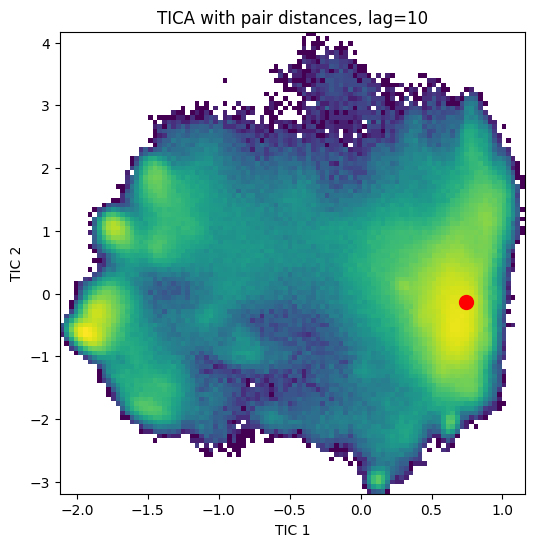

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/7 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/7 [00:00<?, ?it/s]

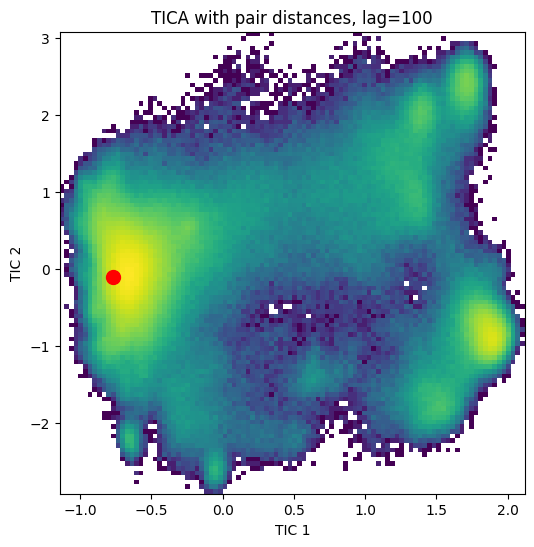

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/7 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/7 [00:00<?, ?it/s]

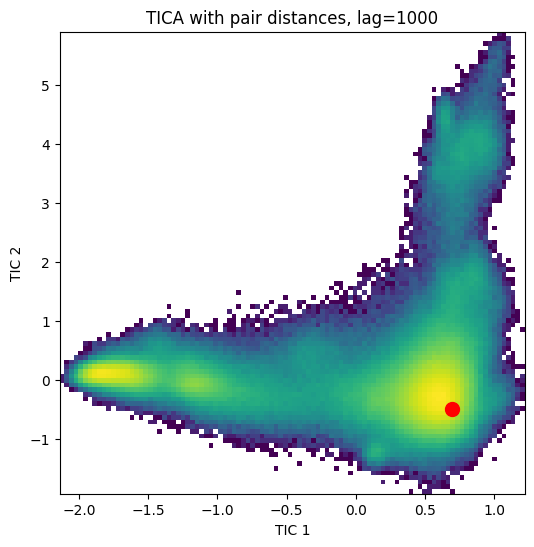

In [16]:
# TICA with pair distances
pdb_state = md.load(pdb_path)
pdb_state_ca_pair_distances, pdb_resid_pairs = md.compute_contacts(pdb_state, scheme="ca", contacts=ca_resid_pair, periodic=False)

for lag in (10, 100, 1000):
	data = ca_pair_contacts
	tica_obj = pyemma.coordinates.tica(data, lag=lag, dim=2)
	tica_data = tica_obj.get_output()[0]
	x = tica_data[:, 0]
	y = tica_data[:, 1]

	pdb_tica_data = tica_obj.transform(pdb_state_ca_pair_distances)
	pdb_tica_x = pdb_tica_data[:, 0]
	pdb_tica_y = pdb_tica_data[:, 1]

	# Plot
	fig = plt.figure(figsize=(6, 6))
	ax = fig.add_subplot(111)
	ax.hist2d(x, y, bins=100, norm=LogNorm())
	ax.scatter(pdb_tica_x, pdb_tica_y, color="red", s=100)
	ax.set_xlabel("TIC 1")
	ax.set_ylabel("TIC 2")
	plt.title(f"TICA with pair distances, lag={lag}")
	plt.savefig(f'../data/{molecule}/{molecule}_tica_model_lag{lag}.png')
	plt.show()
	plt.close()

	with open(f'../data/{molecule}/{molecule}_tica_model_lag{lag}.pkl', 'wb') as f:
		pickle.dump(tica_obj, f)

In [19]:
# TICA with pair distances
pdb_state = md.load(pdb_path)
pdb_state_ca_pair_distances, pdb_resid_pairs = md.compute_contacts(pdb_state, scheme="ca", contacts=ca_resid_pair, periodic=False)
pdb_state_ca_pair_distances = cad2switch(pdb_state_ca_pair_distances)
data_switch = cad2switch(ca_pair_contacts)

for lag in (10, 100, 1000):
	tica_obj = pyemma.coordinates.tica(data_switch, lag=lag, dim=2)
	tica_data = tica_obj.get_output()[0]
	x = tica_data[:, 0]
	y = tica_data[:, 1]

	pdb_tica_data = tica_obj.transform(pdb_state_ca_pair_distances)
	pdb_tica_x = pdb_tica_data[:, 0]
	pdb_tica_y = pdb_tica_data[:, 1]

	# Plot
	fig = plt.figure(figsize=(6, 6))
	ax = fig.add_subplot(111)
	ax.hist2d(x, y, bins=100, norm=LogNorm())
	ax.scatter(pdb_tica_x, pdb_tica_y, color="red", s=100)
	ax.set_xlabel("TIC 1")
	ax.set_ylabel("TIC 2")
	plt.title(f"TICA with pair distances, lag={lag}")
	plt.savefig(f'../data/{molecule}/{molecule}_tica_model_switch_lag{lag}.png')
	plt.show()
	plt.close()

	with open(f'../data/{molecule}/{molecule}_tica_model_switch_lag{lag}.pkl', 'wb') as f:
		pickle.dump(tica_obj, f)

/tmp/ipykernel_4072459/1269659341.py:7: RuntimeWarning: invalid value encountered in divide
  return (1 - np.power(cad / cutoff, 6)) / (1 - np.power(cad / cutoff, 12))
/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/7 [00:00<?, ?it/s]

InvalidDataInStreamException: Found invalid values in chunk in trajectory index 0 at chunk [177546, 355082] within frames (array([74275]), array([328])).

# Analysis

## States by RMSD

In [ ]:
def rmsd_to_refpdb(
	traj: md.Trajectory,
	reference_traj: md.Trajectory,
	atom_type: str = "ca",
) -> np.ndarray:
	"""
	Generate binary labels for folded/unfolded states based on RMSD
	"""
	if atom_type == "ca":
		atom_indices = traj.topology.select("name CA")
	else:
		atom_indices = None
	
	rmsd = md.rmsd(
		target = traj,
		reference = reference_traj,
		atom_indices = atom_indices
	)
	return rmsd

### Folded

In [ ]:
ref_pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/notebook/{molecule}_from_mae.pdb"
ref_pdb_traj = md.load_pdb(ref_pdb_path)
rmsd = rmsd_to_refpdb(
    traj = all_traj,
    reference_traj = ref_pdb_traj,
)

print(rmsd.mean())
plt.hist(
    rmsd,
    bins=100,
    # log=True,
    color=blue,
)
plt.show()

In [ ]:
print(all_traj)
print(rmsd.shape)

# torch.save(
#     torch.from_numpy(rmsd),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-rmsd.pt"
# )
# torch.save(
#     torch.from_numpy(rmsd < 0.3),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-label-rmsd-folded.pt"
# )

In [ ]:
# TICA with pair distances

pdb_state = md.load(pdb_path)
lag = 10
ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(pdb_state.topology.residues), 2)]
)
data, resid_pairs = md.compute_contacts(
	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
tica_obj = pyemma.coordinates.tica(data, lag=lag, dim=2)
tica_data = tica_obj.get_output()[0]
x = tica_data[:, 0]
y = tica_data[:, 1]

pdb_state_ca_pair_distances, pdb_resid_pairs = md.compute_contacts(pdb_state, scheme="ca", contacts=ca_resid_pair, periodic=False)
pdb_tica_data = tica_obj.transform(pdb_state_ca_pair_distances)
pdb_tica_x = pdb_tica_data[:, 0]
pdb_tica_y = pdb_tica_data[:, 1]

In [ ]:
# Plot TICA with RMSD colors
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
sc = ax.hexbin(
	x, y,
	C=rmsd,
	gridsize=120,
	cmap='viridis_r',
	reduce_C_function=np.mean,
 	mincnt=3,
  	linewidths=0,
  	edgecolors="none",
   	alpha=0.95,
)
ax.scatter(
    pdb_tica_x,
    pdb_tica_y,
    c="red",
    s=100,
    edgecolors="k",
    linewidths=2,
    label="Folded state",
)
ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
ax.set_title(f"TICA with RMSD colors (lag={lag})")
ax.legend(loc="best")
cb = plt.colorbar(sc, ax=ax)
cb.set_label("CA RMSD to folded (nm)")
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
torch.save(torch.from_numpy(rmsd), f"{save_dir}/{molecule}-{simulation_idx}-rmsd.pt")
# torch.save(torch.from_numpy(label_by_rmsd), f"{save_dir}/{molecule}-{simulation_idx}-label_rmsd.pt")

### Unfolded

In [ ]:
rmsd_loaded = torch.load( f"{save_dir}/{molecule}-{simulation_idx}-rmsd.pt").numpy()
rmsd_max_frame_idx = np.argmax(rmsd_loaded)
rmsd_max_frame = all_traj[rmsd_max_frame_idx]
rmsd_view = nv.show_mdtraj(rmsd_max_frame)
rmsd_view.add_representation("licorice", selection="protein")
rmsd_view

In [ ]:
ref_pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/folded.pdb"
ref_pdb_traj = md.load_pdb(ref_pdb_path)
atom_indices = all_traj.topology.select("name CA")

max_rmsd = md.rmsd(
	target = rmsd_max_frame,
	reference = ref_pdb_traj,
	atom_indices = atom_indices
)
print(max_rmsd)

In [ ]:
# save_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/unfolded.pdb"
# rmsd_max_frame.save_pdb(save_path)

In [ ]:
unfolded_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/unfolded.pdb"
unfolded_traj = md.load_pdb(unfolded_path)
rmsd_to_unfolded = rmsd_to_refpdb(
    traj = all_traj,
    reference_traj = unfolded_traj,
)

print(rmsd_to_unfolded.shape)
print(rmsd_to_unfolded.mean())
plt.hist(
    rmsd_to_unfolded,
    bins=100,
    # log=True,
    color=blue,
)
plt.show()


In [ ]:
torch.save(torch.from_numpy(rmsd_to_unfolded), f"{save_dir}/{molecule}-{simulation_idx}-rmsd_unfolded.pt")

## Secondary structure

In [ ]:
dssp_all = md.compute_dssp(
    all_traj,
    simplified=False
)
print(dssp_all.shape)
print(dssp_all[0])
dssp_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-dssp.npy"
np.save(dssp_path, dssp_all)

In [ ]:
dssp_all = md.compute_dssp(
    all_traj,
    simplified=True
)
print(dssp_all.shape)
print(dssp_all[0])
dssp_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-dssp-simplified.npy"
np.save(dssp_path, dssp_all)

In [ ]:
dssp_loaded = np.load(dssp_path)
print(dssp_loaded.shape)

In [ ]:
dssp_helix = np.array([True if "H" or "G" or "I" in dssp else False for dssp in dssp_all])
print(dssp_helix.shape)
print(dssp_helix[0])

np.save(
    f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-dssp-helix.npy",
    dssp_helix
)

In [ ]:
# Plot TICA with helix colors
pdb_state = md.load(pdb_path)
lag = 10
ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(pdb_state.topology.residues), 2)]
)
data, resid_pairs = md.compute_contacts(
	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
tica_obj = pyemma.coordinates.tica(data, lag=lag, dim=2)
tica_data = tica_obj.get_output()[0]
x = tica_data[:, 0]
y = tica_data[:, 1]
# helix_color = np.array(["red" if dssp else "blue" for dssp in dssp_all])

In [ ]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
sc = ax.hexbin(
	x, y,
	C=dssp_helix,
	gridsize=120,
	cmap='viridis_r',
	reduce_C_function=np.mean,
 	mincnt=3,
  	linewidths=0,
  	edgecolors="none",
   	alpha=0.95,
)
ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
ax.set_title(f"TICA with helix colors (lag={lag})")
ax.legend(loc="best")
cb = plt.colorbar(sc, ax=ax)
cb.set_label("Helix")
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# Create density scatter plot: residue number vs CV value
# Using DSSP data to analyze secondary structure distribution

# First, let's understand the DSSP data structure
print("DSSP data shape:", dssp_all.shape)
print("Number of frames:", dssp_all.shape[0])
print("Number of residues:", dssp_all.shape[1])
print("Sample DSSP data (first frame):", dssp_all[0])

# Convert DSSP labels to numerical values for plotting
# H = Helix, E = Beta sheet, C = Coil/Loop
dssp_to_num = {'H': 1, 'E': 2, 'C': 0}

# Create arrays for plotting
residue_numbers = []
cv_values = []

# Process each frame
for frame_idx in range(dssp_all.shape[0]):
    for residue_idx in range(dssp_all.shape[1]):
        residue_num = residue_idx + 1  # 1-indexed residue numbers
        dssp_label = dssp_all[frame_idx, residue_idx]
        cv_value = dssp_to_num.get(dssp_label, 0)  # Default to 0 for unknown labels
        
        residue_numbers.append(residue_num)
        cv_values.append(cv_value)

residue_numbers = np.array(residue_numbers)
cv_values = np.array(cv_values)

print(f"Total data points: {len(residue_numbers)}")
print(f"Residue range: {residue_numbers.min()} - {residue_numbers.max()}")
print(f"CV value range: {cv_values.min()} - {cv_values.max()}")


In [ ]:
# Create the density scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

# Use hexbin for density visualization
hb = ax.hexbin(residue_numbers, cv_values, 
               gridsize=50, 
               cmap='viridis', 
               mincnt=1,
               linewidths=0.2,
               edgecolors='white',
               alpha=0.8)

# Customize the plot
ax.set_xlabel('Residue Number', fontsize=14)
ax.set_ylabel('Secondary Structure (CV Value)', fontsize=14)
ax.set_title('Density Scatter Plot: Secondary Structure by Residue\n(2JOF Protein)', fontsize=16)

# Set y-axis labels for secondary structure types
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['Coil/Loop (C)', 'Helix (H)', 'Beta Sheet (E)'])

# Set x-axis to show all residues
ax.set_xlim(0.5, 20.5)
ax.set_xticks(range(1, 21))

# Add colorbar
cb = plt.colorbar(hb, ax=ax)
cb.set_label('Number of Observations', fontsize=12)

# Add grid for better readability
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
for residue in range(1, 21):
    mask = residue_numbers == residue
    residue_data = cv_values[mask]
    
    helix_pct = (residue_data == 1).mean() * 100
    sheet_pct = (residue_data == 2).mean() * 100
    coil_pct = (residue_data == 0).mean() * 100
    
    print(f"Residue {residue:2d}: Helix={helix_pct:5.1f}%, Sheet={sheet_pct:5.1f}%, Coil={coil_pct:5.1f}%")


In [ ]:
# Alternative visualization: Discrete scatter plot with jittering
fig, ax = plt.subplots(figsize=(14, 8))

# Add small random jitter to y-values for better visibility
np.random.seed(42)  # For reproducibility
jitter_amount = 0.1
cv_values_jittered = cv_values + np.random.uniform(-jitter_amount, jitter_amount, len(cv_values))

# Create scatter plot with alpha for density visualization
scatter = ax.scatter(residue_numbers, cv_values_jittered, 
                    alpha=0.01, 
                    s=1, 
                    c=cv_values, 
                    cmap='Set1',
                    rasterized=True)

# Customize the plot
ax.set_xlabel('Residue Number', fontsize=14)
ax.set_ylabel('Secondary Structure (CV Value)', fontsize=14)
ax.set_title('Discrete Scatter Plot: Secondary Structure Distribution by Residue\n(2JOF Protein - All Frames)', fontsize=16)

# Set y-axis labels for secondary structure types
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['Coil/Loop (C)', 'Helix (H)', 'Beta Sheet (E)'])

# Set x-axis to show all residues
ax.set_xlim(0.5, 20.5)
ax.set_xticks(range(1, 21))
ax.set_ylim(-0.5, 2.5)

# Add horizontal lines to separate secondary structure types
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=1.5, color='gray', linestyle='--', alpha=0.5)

# Add grid for better readability
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Create a heatmap-style visualization for better density representation
fig, ax = plt.subplots(figsize=(14, 6))

# Calculate the frequency of each secondary structure type for each residue
residue_range = range(1, 21)
ss_types = [0, 1, 2]  # Coil, Helix, Sheet
ss_labels = ['Coil/Loop', 'Helix', 'Beta Sheet']

# Create frequency matrix
freq_matrix = np.zeros((len(ss_types), len(residue_range)))

for i, ss_type in enumerate(ss_types):
    for j, residue in enumerate(residue_range):
        mask = (residue_numbers == residue) & (cv_values == ss_type)
        freq_matrix[i, j] = mask.sum()

# Normalize by total observations per residue to get proportions
total_per_residue = freq_matrix.sum(axis=0)
prop_matrix = freq_matrix / total_per_residue[np.newaxis, :]

# Create the heatmap
im = ax.imshow(prop_matrix, cmap='Blues', aspect='auto', vmin=0, vmax=1)

# Customize the plot
ax.set_xlabel('Residue Number', fontsize=14)
ax.set_ylabel('Secondary Structure Type', fontsize=14)
ax.set_title('Secondary Structure Proportions by Residue\n(2JOF Protein)', fontsize=16)

# Set ticks and labels
ax.set_xticks(range(len(residue_range)))
ax.set_xticklabels(residue_range)
ax.set_yticks(range(len(ss_labels)))
ax.set_yticklabels(ss_labels)

# Add text annotations showing percentages
for i in range(len(ss_types)):
    for j in range(len(residue_range)):
        text = ax.text(j, i, f'{prop_matrix[i, j]:.2f}',
                      ha="center", va="center", color="white" if prop_matrix[i, j] > 0.5 else "black",
                      fontsize=8)

# Add colorbar
cb = plt.colorbar(im, ax=ax)
cb.set_label('Proportion of Time in Structure', fontsize=12)

plt.tight_layout()
plt.show()

# Print the most common secondary structure for each residue
print("\nMost common secondary structure per residue:")
for j, residue in enumerate(residue_range):
    max_idx = np.argmax(prop_matrix[:, j])
    max_prop = prop_matrix[max_idx, j]
    print(f"Residue {residue:2d}: {ss_labels[max_idx]:12s} ({max_prop:.1%})")


# Conclusion